In this project, your goal is to write a software pipeline to identify the lane boundaries in video from a front-facing camera on a car. The camera calibration images, test road images, and videos are available in this repository. Your job is to take what you've learned in this lesson and write a great lane-finding pipeline! Check out the project rubric for details on what's expected in your submission.

In [1]:
import cv2
import glob
import os
import pickle
import numpy as np

In [2]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(nx,ny,0)
pattern_size = (nx, ny)
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
h, w = 0, 0

images = glob.glob('camera_cal/*.jpg')
for fname in images:
    print('processing %s... ' % fname, end='\t')
    img = cv2.imread(fname)
    if img is None:
        print("Failed to load", fname)
        continue
        
    h, w = img.shape[:2]
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, pattern_size)

    # If found, add object points, image points (after refining them)
    if ret:
        cv2.cornerSubPix(gray, corners,(5, 5),(-1, -1), criteria)
    else:
        print('chessboard not found')
        continue
    imgpoints.append(corners.reshape(-1, 2))
    objpoints.append(pattern_points)
    print('ok')
    
# Calculate camera matrix and distortion
ret, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w ,h), None, None)
print("\nRMS:", ret)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients:\n", dist_coefs.ravel())

#new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))
#print("new camera matrix:\n", new_camera_matrix)
    
#         # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         cv2.imshow('img', img)
#         cv2.waitKey(300)
#     cv2.destroyAllWindows()

processing camera_cal/calibration5.jpg... 	chessboard not found
processing camera_cal/calibration13.jpg... 	ok
processing camera_cal/calibration6.jpg... 	ok
processing camera_cal/calibration18.jpg... 	ok
processing camera_cal/calibration14.jpg... 	ok
processing camera_cal/calibration1.jpg... 	chessboard not found
processing camera_cal/calibration12.jpg... 	ok
processing camera_cal/calibration8.jpg... 	ok
processing camera_cal/calibration20.jpg... 	ok
processing camera_cal/calibration2.jpg... 	ok
processing camera_cal/calibration11.jpg... 	ok
processing camera_cal/calibration17.jpg... 	ok
processing camera_cal/calibration16.jpg... 	ok
processing camera_cal/calibration4.jpg... 	chessboard not found
processing camera_cal/calibration19.jpg... 	ok
processing camera_cal/calibration10.jpg... 	ok
processing camera_cal/calibration7.jpg... 	ok
processing camera_cal/calibration15.jpg... 	ok
processing camera_cal/calibration9.jpg... 	ok
processing camera_cal/calibration3.jpg... 	ok

RMS: 0.8453580

In [4]:
# Save the data for easy access
pickle_file = 'calibration.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'camera_matrix': camera_matrix,
                    'dist_coefs': dist_coefs,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.signal import find_peaks_cwt
%matplotlib inline

In [2]:
# Reload the data
pickle_file = 'calibration.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    camera_matrix = pickle_data['camera_matrix']
    dist_coefs = pickle_data['dist_coefs']
    del pickle_data  # Free up memory

print('Calibration result loaded.')
print("camera matrix:\n", camera_matrix)
print("distortion coefficients:\n", dist_coefs.ravel())    

Calibration result loaded.
camera matrix:
 [[  1.15754896e+03   0.00000000e+00   6.65770604e+02]
 [  0.00000000e+00   1.15281337e+03   3.88878065e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
distortion coefficients:
 [ -2.39009071e-01  -8.20017752e-02  -8.42601955e-04  -6.69937530e-05
   1.03787389e-01]


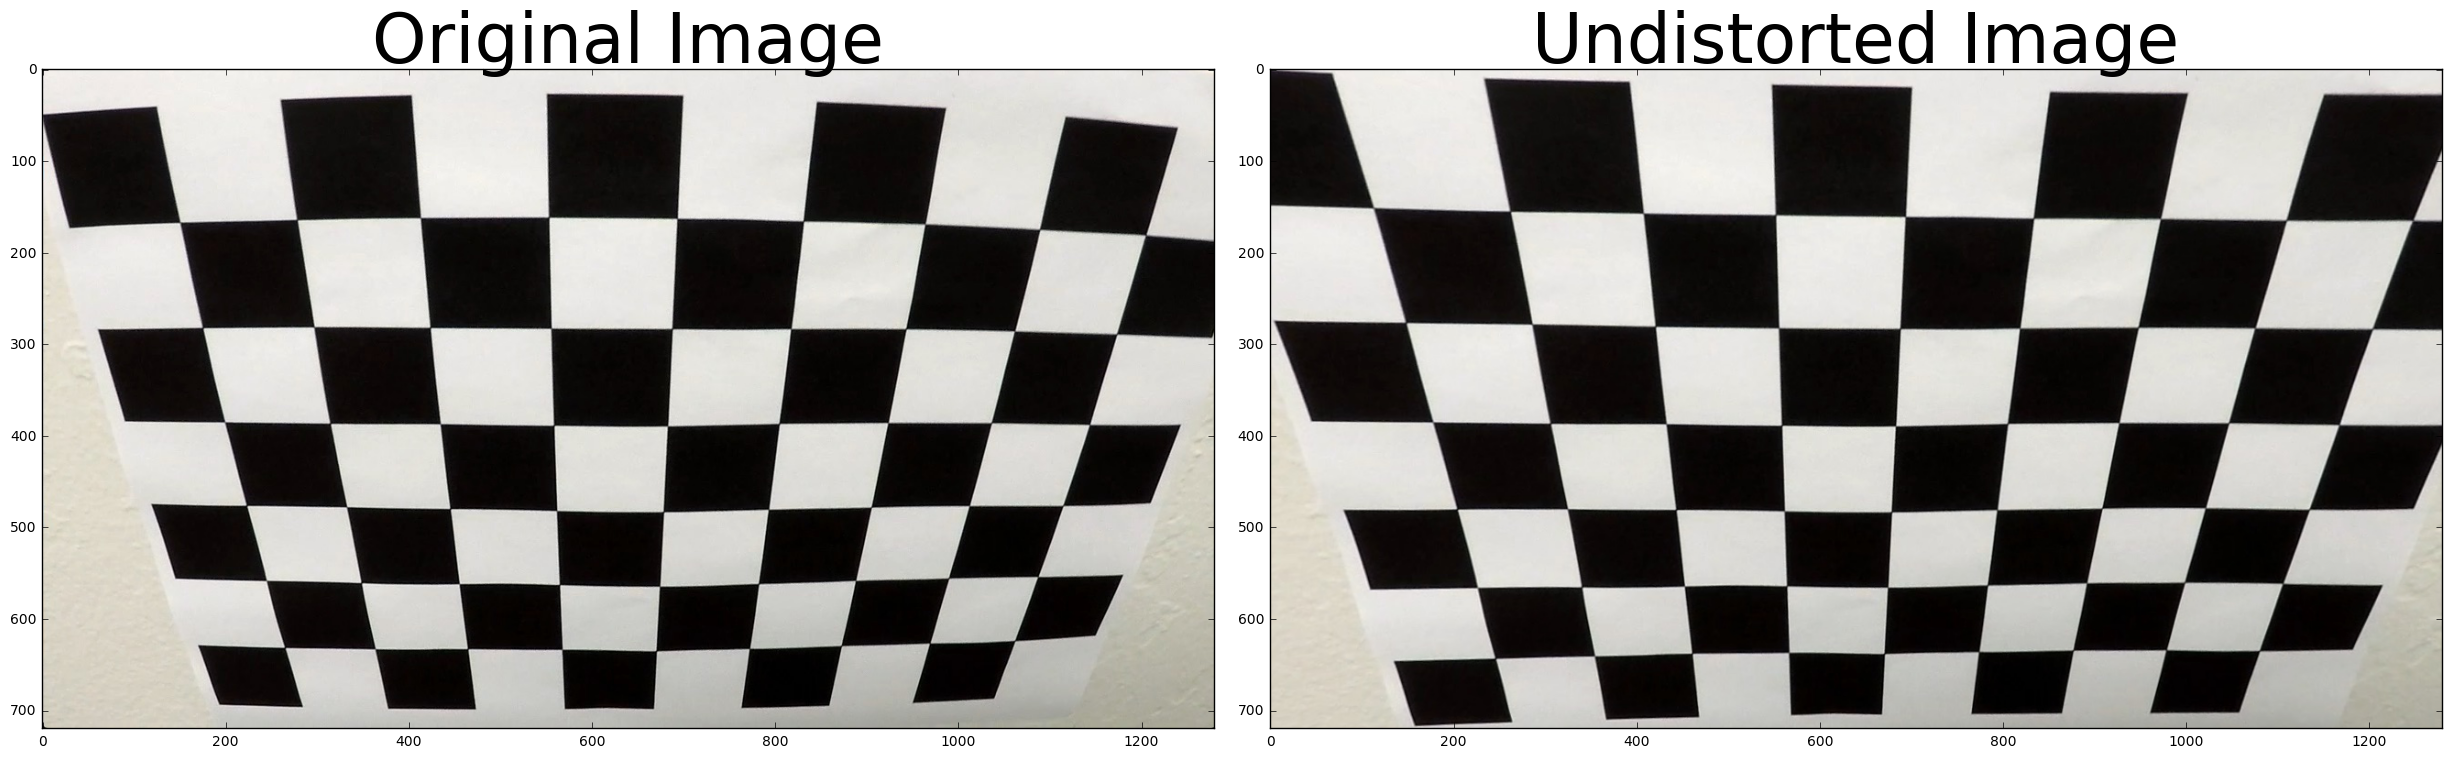

In [3]:
img = cv2.imread('camera_cal/calibration2.jpg')
undistorted = cv2.undistort(img, camera_matrix, dist_coefs, None, camera_matrix)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units"
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
class SlidingWindow():
    def __init__(self):
        self.num = 8
        self.mask_left = np.array([])
        self.mask_right = np.array([])
        # search +- 50 pixels
        self.width = 40 
        self.height = None
        self.center = np.zeros([self.num, 2])
        self.confidence = 0
        # slide +- 50 pixels
        self.search_window = 5
        self.slide_step = 0

In [5]:
def undistort(image, camera_matrix, dist_coefs):
    undist_image = cv2.undistort(image, camera_matrix, dist_coefs, None, camera_matrix)
    return undist_image

def color_thresholding(image, thresh_H = (15, 100), thresh_S = (90, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    # Threshold color channel
    h_binary = cv2.inRange(H, thresh_H[0], thresh_H[1])
    s_binary = cv2.inRange(S, thresh_S[0], thresh_S[1])
    
    # Combine the two binary thresholds
    color_binary = cv2.bitwise_and(h_binary, s_binary)
    return color_binary

def gradient_thresholding(image, thresh_abssx = (30, 150)):
    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abssx = np.absolute(sobelx) # Absolute x derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssx)/255 # Will use this to scale back to 8-bit scale
    abssx = (abssx / scale_factor).astype(np.uint8) #rescaling to 8-bit 
    # Threshold x gradient
    gradient_binary = cv2.inRange(abssx, thresh_abssx[0], thresh_abssx[1])  
    return gradient_binary

def region_of_interest(image, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 255)
    #returning the image only where mask pixels are nonzero
    masked_binary = cv2.bitwise_and(image, mask)
    return masked_binary

def calculate_perspective(src, dst):
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def warp_image(image, M, size):
    warped = cv2.warpPerspective(image, M, size)
    retval, warped_binary = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY)
    return warped_binary

def sliding_window_init(image):
    
    # The lane lines should appear parallel in the warped images
    # With this histogram I am adding up the pixel values along each column in the image
    sliding_win.confidence += 1
    #normalize to 0 & 1
    image = image / 255
    
    # height x width = 720 x 1280
    sliding_win.height = image.shape[0] // sliding_win.num
    sliding_win.mask_left = np.zeros_like(image) 
    sliding_win.mask_right = np.zeros_like(image) 
    
    for i in range(0, sliding_win.num):
        top = i * sliding_win.height
        bottom = (i + 1) * sliding_win.height
        band = image[top:bottom, :]
        histogram = np.sum(band, axis = 0)
        #plt.plot(histogram)
        #peak = find_peaks_cwt(histogram, np.arange(1, warped.shape[1]))
        peak = find_peaks_cwt(histogram, [100], max_distances = [100])
        peak_value = [histogram[index] for index in peak]
        peak_sorted = np.argsort(peak_value) 
        # reverse order
        peak_sorted = peak_sorted[::-1]
        
        temp_left = -1
        temp_right = -1
        
        # Find one line - Seems useful but it is so hard to determine it belongs to left or right
        # You can assume it by position but not alway true
        if (peak_sorted.shape[0] == 1):
            if (peak[peak_sorted[0]] >= image.shape[1] / 4 and peak[peak_sorted[0]] < image.shape[1] * 1 / 2):
                temp_left = peak[peak_sorted[0]]
                #sliding_win.mask_left[top:bottom, (peak[peak_sorted[0]] - sliding_win.width) : (peak[peak_sorted[0]] + sliding_win.width)] = 1
            elif(peak[peak_sorted[0]] >= image.shape[1] / 2 and peak[peak_sorted[0]] <= image.shape[1] * 3 / 4):
                temp_right = peak[peak_sorted[0]]
                #sliding_win.mask_right[top:bottom, (peak[peak_sorted[0]] - sliding_win.width) : (peak[peak_sorted[0]] + sliding_win.width)] = 1
        elif (peak_sorted.shape[0] > 1): # Find two lines - accumulate confidence
            if (peak[peak_sorted[0]] < peak[peak_sorted[1]]):
                temp_left = peak[peak_sorted[0]]
                temp_right = peak[peak_sorted[1]]
            else:
                temp_left = peak[peak_sorted[1]]
                temp_right = peak[peak_sorted[0]]
                                
        # Have none previous data
        if (sliding_win.center[i, 0] == 0 or sliding_win.center[i, 1] == 0):
            if (temp_left != -1):
                sliding_win.center[i, 0] = temp_left
            if (temp_right != -1):    
                sliding_win.center[i, 1] = temp_right
        else:
            diff_left = np.absolute(sliding_win.center[i, 0] - temp_left)
            diff_right = np.absolute(sliding_win.center[i, 1] - temp_right)
            if (temp_left != -1 and diff_left <= 50):
                sliding_win.center[i, 0] = temp_left
            if (temp_right != -1 and diff_right <= 50):
                sliding_win.center[i, 1] = temp_right
                    
        sliding_win.mask_left[top:bottom, (sliding_win.center[i, 0] - sliding_win.width) : (sliding_win.center[i, 0] + sliding_win.width)] = 1        
        sliding_win.mask_right[top:bottom, (sliding_win.center[i, 1] - sliding_win.width) : (sliding_win.center[i, 1] + sliding_win.width)] = 1
                        
    warped_left_binary = cv2.bitwise_and(image, sliding_win.mask_left)
    warped_left_binary = np.uint8(warped_left_binary) * 255

    warped_right_binary = cv2.bitwise_and(image, sliding_win.mask_right)
    warped_right_binary = np.uint8(warped_right_binary) * 255

    
    return warped_left_binary, warped_right_binary

def sliding_window_search(image, side):
    if (sliding_win.confidence < 20):
        sliding_win.confidence += 1
    #normalize to 0 & 1
    image = image / 255
    if (side == 0):
        sliding_win.mask_left = np.zeros_like(image) 
    else:
        sliding_win.mask_right = np.zeros_like(image) 
    
    count_sum = 0
    for i in range(0, sliding_win.num):
        top = i * sliding_win.height
        bottom = (i + 1) * sliding_win.height
        band = image[top:bottom, :]
        
        band_mask = np.zeros_like(band)        
        max_count = 0
        index = 0
        for j in range(-sliding_win.search_window, sliding_win.search_window + 1):
                band_mask[:, (sliding_win.center[i, side] + j - sliding_win.width) : (sliding_win.center[i, side] + j + sliding_win.width)] = 1        
                band_masked_image = cv2.bitwise_and(band, band_mask)
                current_count = cv2.countNonZero(band_masked_image);
                if (current_count > max_count):
                    max_count = current_count
                    index = j
        
        if (index > 0):
            sliding_win.slide_step = 5
        elif (index < 0):
            sliding_win.slide_step = -5
        #sliding_win.center[i, side] += index
        
        if (max_count <=50 and i < sliding_win.num - 1):
            #sliding_win.confidence -= 2
            #sliding_win.mask_left remains zeros_like
            #search back 
            #sliding_win.center[i, side] -= sliding_win.slide_step
            sliding_win.center[i, side] = sliding_win.center[i + 1, side]
        else:
            sliding_win.center[i, side] += index
        
        if (side == 0):
            sliding_win.mask_left[top:bottom, (sliding_win.center[i, side] - sliding_win.width) : (sliding_win.center[i, side] + sliding_win.width)] = 1
        else:
            sliding_win.mask_right[top:bottom, (sliding_win.center[i, side] - sliding_win.width) : (sliding_win.center[i, side] + sliding_win.width)] = 1

        count_sum += max_count
               
    # not enough points found, maybe lost tracktry to initialize search process again
    # Maybe clear the mask to zeros_like  ???????????????
    if (count_sum <= 500):
        #sliding_win.confidence -= 3
        sliding_win.confidence = 0

    if (side == 0):
        warped_mask_binary = cv2.bitwise_and(image, sliding_win.mask_left)
    else:
        warped_mask_binary = cv2.bitwise_and(image, sliding_win.mask_right)
        
    warped_mask_binary = np.uint8(warped_mask_binary) * 255
    return warped_mask_binary


def find_lines(image, previous_fit):
    pixel_points = cv2.findNonZero(image)
    pixel_points = np.reshape(pixel_points, (-1, 2))
  
    allx = pixel_points[:, 0]
    ally = pixel_points[:, 1]
    
    #Fit a second order polynomial to each fake lane line
    current_fit = np.polyfit(ally, allx, 2)
    
    diffs = np.fabs(current_fit - previous_fit)
    font = cv2.FONT_HERSHEY_SIMPLEX

#     print(current_fit)
#     print(previous_fit)
#     print(diffs)
#     print(diffs[0])
# #     print(diffs[0][0])
# #     print(diffs[0][1])
# #     print(diffs[0][2])

    if (sliding_win.confidence >= 15):
        if (diffs[0] >= 0.1 or diffs[0] >= 0.5 or diffs[0] >= 20):
        #if (previous_fit != np.array([False])):
            current_fit = previous_fit
    
#    cv2.putText(image, str(diffs), (10, 50), font, 1, (255, 255, 255), 2)    
    #cv2.putText(image, str(diffs[1]), (10, 150), font, 2, (255, 255, 255), 2)    
    #cv2.putText(image, str(diffs[2]), (10, 250), font, 2, (255, 255, 255), 2)    
#     diffs_val = np.sum(diffs)
#     if (sliding_win.confidence > 20 and diffs_val >= 1):
#         current_fit = previous_fit
    #print (diffs)
    
    yvals = np.linspace(0, 100, num = 101) * 7.2  # to cover same y-range as image
    fitx = current_fit[0] * yvals ** 2 + current_fit[1] * yvals + current_fit[2]
        
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700 # meteres per pixel in x dimension
    y_eval = np.max(yvals)
    fit_cr = np.polyfit(ally * ym_per_pix, allx * xm_per_pix, 2)
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 3380.7 m    3189.3 m
    radius_of_curvature = ((1 + (2 * fit_cr[0] * y_eval + fit_cr[1]) ** 2) ** 1.5) \
                                 / np.absolute(2 * fit_cr[0])
    radius_of_curvature = int(radius_of_curvature)

    line_image = np.zeros_like(image)  # creating a blank to draw lines on
    line_image = np.dstack((line_image, line_image, line_image))
    
    yvals = yvals.reshape(-1, 1)
    fitx = fitx.reshape(-1, 1)
    
    pts = np.hstack(([fitx, yvals]))  
    cv2.polylines(line_image, np.int_([pts]), False,(0, 0, 255), 20)   
    
    return line_image, allx, ally, current_fit, radius_of_curvature, pts

def draw_freespace(image, left_pts, right_pts):
    right_pts = right_pts[::-1]
    pts = np.vstack((left_pts, right_pts))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(image, np.int_([pts]), (0, 255, 0))
    return image 

In [10]:
def process_image(image):    
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # image loaded from matplotlib or moviepy - RGB
    # image processed in OpenCV - BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)    
    height, width, channel = image.shape
    
    #If more information needed, you should use
    #undist_img = cv2.undistort(image, camera_matrix, dist_coefs, None, new_camera_matrix)
    undist = undistort(image, camera_matrix, dist_coefs)
    
    # Thresholding
    color_binary = color_thresholding(undist, thresh_H = (15, 100), thresh_S = (90, 255))
    gradient_binary = gradient_thresholding(undist, thresh_abssx = (30, 150))
    
    # Combine the two binary thresholds
    combined_binary = cv2.bitwise_or(color_binary, gradient_binary)
    
    # Next we'll create a masked image using cv2.fillPoly()
    vertices = np.array([[(0, height),
                          (width * 0.45, height * 0.62),
                          (width * 0.55, height * 0.62),
                          (width, height)]], dtype=np.int32)
    
    
    # Add mask
    masked_binary = region_of_interest(combined_binary, vertices)
    

    src = np.float32(vertices)
    dst = np.float32([[width / 4, height],
                      [width / 4, 0], 
                      [width * 3 / 4, 0], 
                      [width * 3 / 4, height]])
    
    #Because ultimately we want to measure the curvature of the lines
    #And to do that, we need to transform to a top-down view.
    M, Minv = calculate_perspective(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped_binary = warp_image(masked_binary, M, (width, height))
    
    # Add another mask by implement sliding window search algorithm
    
    if (sliding_win.confidence <= 15):
        warped_left_binary, warped_right_binary = sliding_window_init(warped_binary)
    else:
        # 0 -> Left, 1 -> Right
        warped_left_binary = sliding_window_search(warped_binary, 0)
        warped_right_binary = sliding_window_search(warped_binary, 1)
    
    sliding_window_img = cv2.bitwise_or(sliding_win.mask_left, sliding_win.mask_right)
    
    line_left, left_line.allx, left_line.ally, left_line.current_fit, left_line.radius_of_curvature, left_pts = find_lines(warped_left_binary, left_line.current_fit)
    line_right, right_line.allx, right_line.ally, right_line.current_fit, right_line.radius_of_curvature, right_pts = find_lines(warped_right_binary, right_line.current_fit)
       
    line_image = cv2.bitwise_or(line_left, line_right)
    line_image = draw_freespace(line_image, left_pts, right_pts)
    
    # Warp back
    warped_inv = warp_image(line_image, Minv, (width, height))
    # Add to original image
    result = cv2.addWeighted(undist, 1, warped_inv, 1, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    curverad_str = str(left_line.radius_of_curvature) + ", " + str(right_line.radius_of_curvature) + ", " + str(sliding_win.confidence)
    cv2.putText(result, curverad_str, (10,height - 50), font, 4, (255, 255, 255), 2)    
    
    
# #   cv2.imshow('output_H', h_binary)
# #   cv2.imshow('output_S', s_binary)
# #   cv2.imshow('output_combine_color', color_binary)
# #   cv2.imshow('output_grad', sxbinary)
    
#     cv2.imshow('input', image)
#     cv2.imshow('output_combine', combined_binary)
#     cv2.imshow('mask', masked_binary)
#     cv2.imshow('warped', warped_binary)
#     cv2.imshow('slide', sliding_window_img)
#     cv2.imshow('warped_left', warped_left_binary)
#     cv2.imshow('warped_right', warped_right_binary)
#     cv2.imshow('line', line_image)
#     cv2.imshow('result', result)
    
#     cv2.waitKey(1)
    
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result


In [7]:
left_line = Line()
right_line = Line()
sliding_win = SlidingWindow()
output_video1 = 'project_video_output.mp4'
input_video1 = VideoFileClip("project_video.mp4")
output_clip1 = input_video1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip1.write_videofile(output_video1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:43<00:00,  4.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 32min 40s, sys: 5.8 s, total: 32min 46s
Wall time: 4min 44s


(-0.5, 1279.5, 719.5, -0.5)

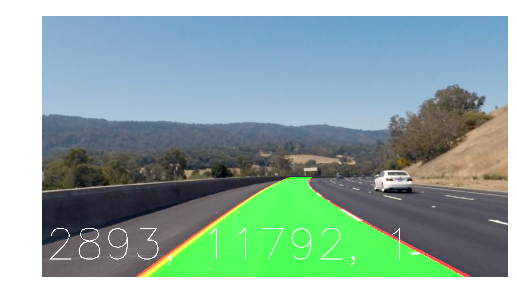

In [13]:
left_line = Line()
right_line = Line()
sliding_win = SlidingWindow()
img = mpimg.imread('test_images/test3.jpg')
out = process_image(img)
plt.imshow(out)
plt.axis('off')

In [8]:
project_output = 'project_video_output.mp4'
HTML("""
<video width="640" height="320" controls>
  <source src="{0}">
</video>
""".format(project_output))